In [3]:
import pandas as pd

df = pd.read_csv('data/data.csv')

df.head()

,Time,Protcol,Flag,Family,Clusters,SeddAddress,ExpAddress,BTC,USD,Netflow_Bytes,IPaddress,Threats,Port,Prediction
0,50,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,500,5,A,Bonet,5061,SS
1,40,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,504,8,A,Bonet,5061,SS
2,30,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,508,7,A,Bonet,5061,SS
3,20,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,512,15,A,Bonet,5061,SS
4,57,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,516,9,A,Bonet,5061,SS


In [4]:
df.info()
df.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149043 entries, 0 to 149042
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Time           149043 non-null  int64 
 1   Protcol        149043 non-null  object
 2   Flag           149043 non-null  object
 3   Family         149043 non-null  object
 4   Clusters       149043 non-null  int64 
 5   SeddAddress    149043 non-null  object
 6   ExpAddress     149043 non-null  object
 7   BTC            149043 non-null  int64 
 8   USD            149043 non-null  int64 
 9   Netflow_Bytes  149043 non-null  int64 
 10  IPaddress      149043 non-null  object
 11  Threats        149043 non-null  object
 12  Port           149043 non-null  int64 
 13  Prediction     149043 non-null  object
dtypes: int64(6), object(8)
memory usage: 15.9+ MB


,Time,Clusters,BTC,USD,Netflow_Bytes,Port
count,149043.000000,149043.000000,149043.000000,149043.000000,149043.000000,149043.000000
mean,21.466979,2.349295,30.554605,14863.441114,2021.278651,5063.949967
std,15.883598,2.828759,101.447102,26849.434659,2271.420987,2.696011
min,-10.000000,1.000000,1.000000,1.000000,1.000000,5061.000000
25%,8.000000,1.000000,8.000000,512.000000,353.000000,5062.000000
50%,19.000000,1.000000,13.000000,4321.000000,1031.000000,5062.000000
75%,32.000000,2.000000,22.000000,18454.000000,3188.000000,5066.000000
max,96.000000,12.000000,1980.000000,126379.000000,12360.000000,5068.000000


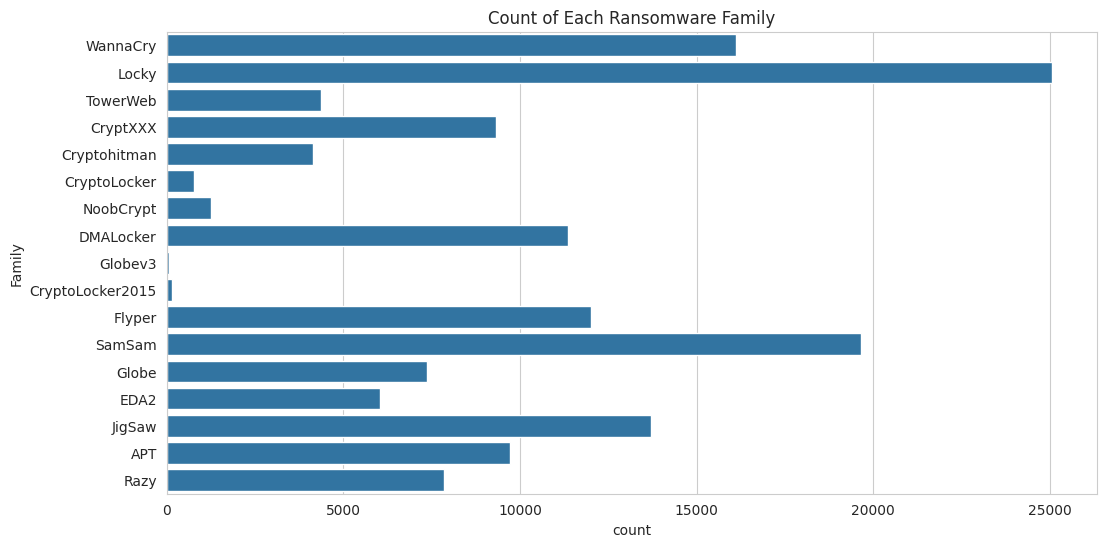

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Family') 
plt.title('Count of Each Ransomware Family')
plt.show()


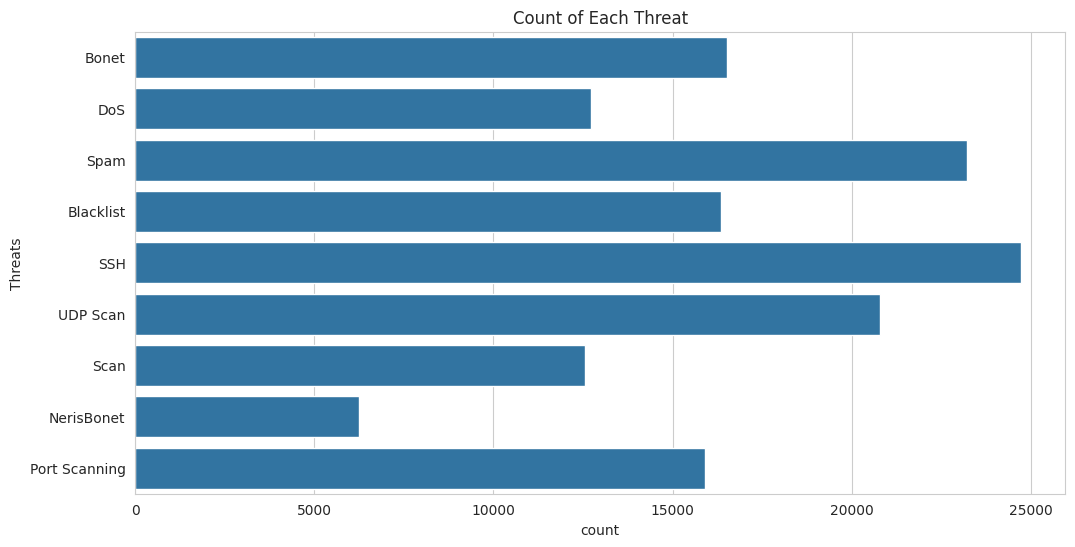

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Threats')
plt.title('Count of Each Threat')
plt.show()

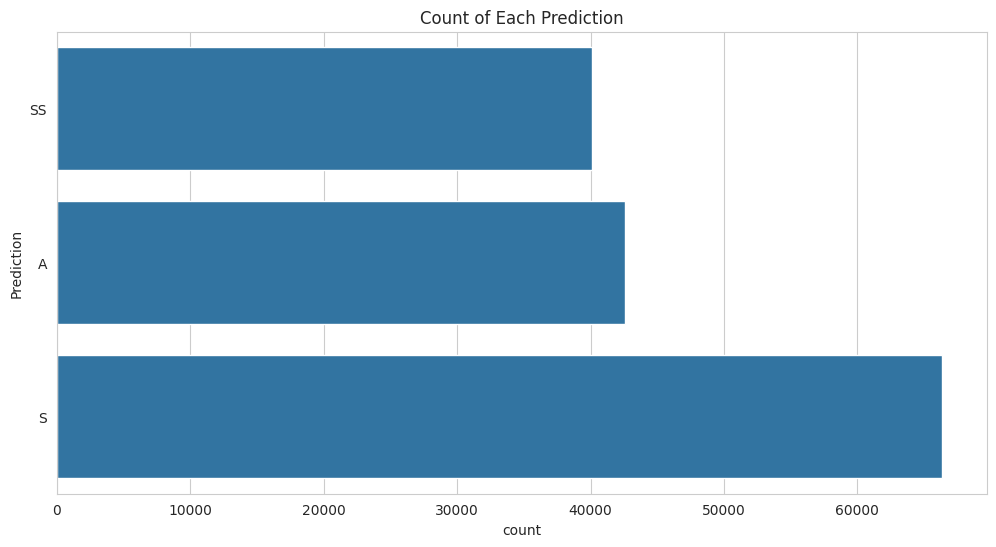

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Prediction')
plt.title('Count of Each Prediction')
plt.show()

In [14]:
df = df[df['Time'] >= 0]

df.reset_index(drop=True, inplace=True)
df.shape

(148904, 14)

In [15]:
df = df[df['ExpAddress'] != '1']
df.shape

(148831, 14)